In [64]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams

In [75]:
data = np.genfromtxt('x50.csv',delimiter=',') # read Paraview slice
np.shape(data)

(12514, 15)

In [76]:
def generateBCT(data):
    """Return y-distance and the coordinates of the barycentric triangle locations. 
       Data must be spanwise periodic"""
    # load data into arrays
    upup = data[1:,0] # stress (resolved or subgrid)
    upvp = data[1:,1]
    upwp = data[1:,2]
    vpvp = data[1:,3]
    vpwp = data[1:,4]
    wpwp = data[1:,5]

    u    = data[1:,-6] 
    v    = data[1:,-5]
    w    = data[1:,-4]

    x    = data[1:,-3]
    y    = data[1:,-2]
    z    = data[1:,-1]

    Y    = np.unique(y)

    # average over spanwise coordinate (z)

    T11  = np.zeros(len(Y))
    T12  = np.zeros(len(Y))
    T13  = np.zeros(len(Y))
    T22  = np.zeros(len(Y))
    T23  = np.zeros(len(Y))
    T33  = np.zeros(len(Y))
    U    = np.zeros(len(Y))

    for _ in range(len(Y)):
        T11[_] = np.average(upup[y == Y[_]])
        T12[_] = np.average(upvp[y == Y[_]])
        T13[_] = np.average(upwp[y == Y[_]])
        T22[_] = np.average(vpvp[y == Y[_]])
        T23[_] = np.average(vpwp[y == Y[_]])
        T33[_] = np.average(wpwp[y == Y[_]])
        U[_]   = np.average(u[y == Y[_]])


    # compute barycentric map coordinates (L. Jofre)

    # limiting states
    x1c    = np.matrix( [ 0.0 , 0.0 ] )
    x2c    = np.matrix( [ 1.0 , 0.0 ] )
    x3c    = np.matrix( [ 0.5 , np.sqrt(3.0)/2.0 ] )

    Xcoord = np.zeros(len(Y))
    Ycoord = np.zeros(len(Y))

    for _ in range(len(Y)):
        reynolds_stress_tensor = np.array([[ T11[_] , T12[_] , T13[_] ],
                                            [ T12[_] , T22[_] , T23[_] ],
                                            [ T13[_] , T23[_] , T33[_] ]])
        trace = T11[_] + T22[_] + T33[_] + 1.0e-20
        anisotropy_tensor = (1.0/trace)*reynolds_stress_tensor - (1.0/3.0)*np.array( [[ 1.0 , 0.0 , 0.0 ],
                                                                                       [ 0.0 , 1.0 , 0.0 ],
                                                                                       [ 0.0 , 0.0 , 1.0 ]])
        eigenvalues_anisotropy_tensor = np.linalg.eigvalsh(anisotropy_tensor)
        sorted_eigenvalues_anisotropy_tensor = sorted(eigenvalues_anisotropy_tensor, reverse=True)
        xbc = x1c*( sorted_eigenvalues_anisotropy_tensor[0] - sorted_eigenvalues_anisotropy_tensor[1] ) + x2c*( 2.0*sorted_eigenvalues_anisotropy_tensor[1] - 2.0*sorted_eigenvalues_anisotropy_tensor[2] ) + x3c*( 3.0*sorted_eigenvalues_anisotropy_tensor[2] + 1 )

        Xcoord[_] = xbc[0,0]
        Ycoord[_] = xbc[0,1]
    
    return Y, Xcoord, Ycoord

In [77]:
def plotBCT(Y, xBCT, yBCT):
    """Plot the barycentric triangle; colour by y-distance"""
    fig = plt.figure(figsize=[1.5*6.4, 1.5*4.8])
    ax = fig.add_subplot(111)
    font = {'size'   : 22}
    matplotlib.rc('font', **font)

    rcParams['mathtext.fontset'] = 'stix'
    rcParams['font.family'] = 'STIXGeneral'
    ax.axis('equal')
    cm = plt.cm.get_cmap('viridis')
    sc = ax.scatter(xBCT,yBCT,c=Y,cmap=cm) # color by y-distance 
    ax.plot([1, 0.5], [0, 0.866], 'k-')
    ax.plot([0, 0.5], [0, 0.866], 'k-')
    ax.plot([0, 1], [0, 0], 'k-')
    ax.plot([0.5, 1.01, 0.1], [-0.01, 0.5, 0.88], 'w.') 
    ax.text(0-.05,0-.05,'1C')
    ax.text(1,0-.05,'2C')
    ax.text(0.5-.025,0.866+.025,'3C')
    ax.patch.set_visible(False)
    ax.axis('off')
    cbar = plt.colorbar(sc)
    cbar.set_label('y-distance')
    plt.show()

In [78]:
Y, xBCT, yBCT = generateBCT(data)

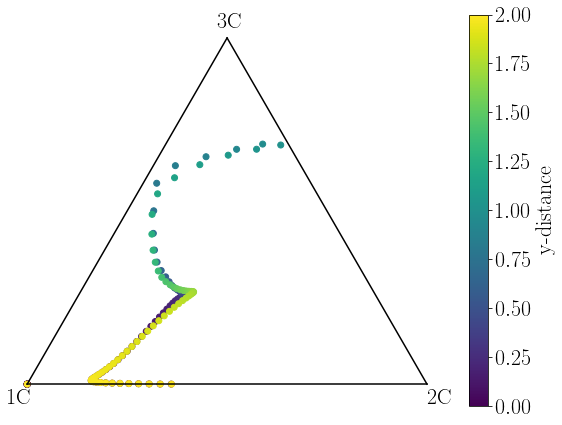

In [79]:
plotBCT(Y, xBCT, yBCT)